# Superconduct dataset - linear regression

The objective value and the all gradient descents are saved in a pickle file. Thus, it is possible to play with results without need to recompute everything (it takes several hours). 
However, the transformed data is not saved because it can be generated without random. Thus to regenerate figures, be sure to intialy run the first cells of the notebook (those devoted to data preparation).

In [1]:
# Add below current directory to path
# Notebook cannot import any code without this line !!!!
import sys; sys.path.insert(0, '..')

import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import IntSlider, interact
from math import sqrt

from sklearn.preprocessing import scale

from tqdm import tqdm, trange # For progress bar
%matplotlib inline
%load_ext autoreload
%autoreload 2

from src.models.CostModel import LogisticModel, RMSEModel, build_several_cost_model

from src.machinery.GradientDescent import ArtemisDescent, FL_VanillaSGD
from src.machinery.GradientUpdateMethod import ArtemisUpdate
from src.machinery.Parameters import *
from src.machinery.PredefinedParameters import *

from src.utils.ErrorPlotter import *
from src.utils.Constants import *
from src.utils.DataClustering import *
from src.utils.DataPreparation import build_data_logistic, add_bias_term
from src.utils.Utilities import pickle_loader, pickle_saver
from src.utils.runner.RunnerUtilities import *
from src.utils.runner.ResultsOfSeveralDescents import ResultsOfSeveralDescents

filename = "ds-superconduct"

nb_devices_for_the_run = 100
nb_devices_sampled = 10

In [2]:
import pandas as pd
data = pd.read_csv('../dataset/superconduct/train.csv', sep=",")
data.head()

,number_of_elements,mean_atomic_mass,wtd_mean_atomic_mass,gmean_atomic_mass,wtd_gmean_atomic_mass,entropy_atomic_mass,wtd_entropy_atomic_mass,range_atomic_mass,wtd_range_atomic_mass,std_atomic_mass,...,wtd_mean_Valence,gmean_Valence,wtd_gmean_Valence,entropy_Valence,wtd_entropy_Valence,range_Valence,wtd_range_Valence,std_Valence,wtd_std_Valence,critical_temp
0,4,88.944468,57.862692,66.361592,36.116612,1.181795,1.062396,122.90607,31.794921,51.968828,...,2.257143,2.213364,2.219783,1.368922,1.066221,1,1.085714,0.433013,0.437059,29.0
1,5,92.729214,58.518416,73.132787,36.396602,1.449309,1.057755,122.90607,36.161939,47.094633,...,2.257143,1.888175,2.210679,1.557113,1.047221,2,1.128571,0.632456,0.468606,26.0
2,4,88.944468,57.885242,66.361592,36.122509,1.181795,0.975980,122.90607,35.741099,51.968828,...,2.271429,2.213364,2.232679,1.368922,1.029175,1,1.114286,0.433013,0.444697,19.0
3,4,88.944468,57.873967,66.361592,36.119560,1.181795,1.022291,122.90607,33.768010,51.968828,...,2.264286,2.213364,2.226222,1.368922,1.048834,1,1.100000,0.433013,0.440952,22.0
4,4,88.944468,57.840143,66.361592,36.110716,1.181795,1.129224,122.90607,27.848743,51.968828,...,2.242857,2.213364,2.206963,1.368922,1.096052,1,1.057143,0.433013,0.428809,23.0


In [3]:
with pd.option_context('display.max_columns', 80):
    print(data.describe(include='all'))

       number_of_elements  mean_atomic_mass  wtd_mean_atomic_mass  \
count        21263.000000      21263.000000          21263.000000   
mean             4.115224         87.557631             72.988310   
std              1.439295         29.676497             33.490406   
min              1.000000          6.941000              6.423452   
25%              3.000000         72.458076             52.143839   
50%              4.000000         84.922750             60.696571   
75%              5.000000        100.404410             86.103540   
max              9.000000        208.980400            208.980400   

       gmean_atomic_mass  wtd_gmean_atomic_mass  entropy_atomic_mass  \
count       21263.000000           21263.000000         21263.000000   
mean           71.290627              58.539916             1.165608   
std            31.030272              36.651067             0.364930   
min             5.320573               1.960849             0.000000   
25%            58.

In [4]:
dim_notebook = len(data.columns) - 1
print("There is " + str(dim_notebook) + " dimensions.")

There is 81 dimensions.


In [5]:
if data.isnull().values.any():
    print("There is missing value.")
else:
    print("No missing value. Great !")

No missing value. Great !


No transformation has been needed to be applied on data, thus we can directly apply the TSNE on raw panda dataframe.

# Handling non-iid data

There is 100 devices.
Number of points on device 0 : 258
Number of points on device 1 : 424
Number of points on device 2 : 221
Number of points on device 3 : 400
Number of points on device 4 : 89
Number of points on device 5 : 489
Number of points on device 6 : 292
Number of points on device 7 : 203
Number of points on device 8 : 219
Number of points on device 9 : 92
Number of points on device 10 : 376
Number of points on device 11 : 490
Number of points on device 12 : 144
Number of points on device 13 : 160
Number of points on device 14 : 207
Number of points on device 15 : 240
Number of points on device 16 : 296
Number of points on device 17 : 263
Number of points on device 18 : 152
Number of points on device 19 : 143
Number of points on device 20 : 170
Number of points on device 21 : 169
Number of points on device 22 : 67
Number of points on device 23 : 331
Number of points on device 24 : 249
Number of points on device 25 : 306
Number of points on device 26 : 177
Number of points on

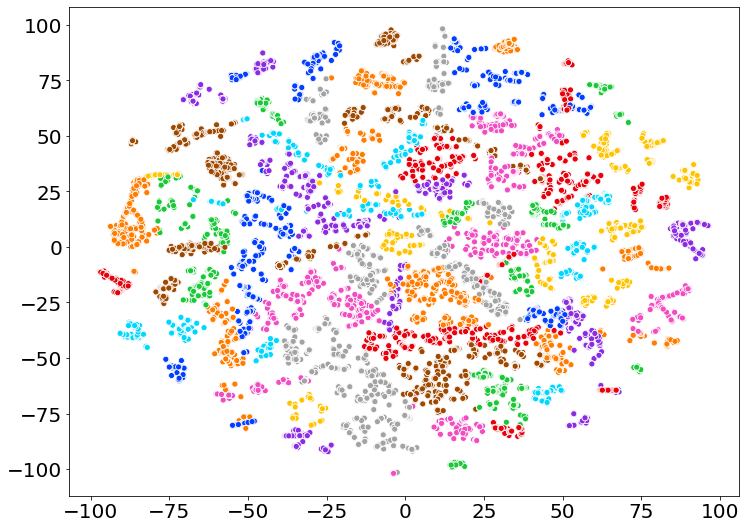

In [6]:
%%time
nb_cluster = nb_devices_for_the_run
embedded_data = pickle_loader("superconduct-tsne".format(filename))
# Finding clusters in the TNSE
predicted_cluster = find_cluster(embedded_data, nb_cluster)
# With the found clusters, splitting data. 
X, Y = clustering_data(data, predicted_cluster, "critical_temp", nb_cluster, scale_Y=True)
dim_notebook = X[0].shape[1] - 1

In [7]:
from src.utils.DataClustering import rebalancing_clusters
X_r, Y_r = rebalancing_clusters(X, Y)

Changing : 
(46, 62)
(577, 40)
Changing : 
(53, 36)
(551, 57)
Number of points on device 0 : 258
Number of points on device 1 : 424
Number of points on device 2 : 221
Number of points on device 3 : 400
Number of points on device 4 : 89
Number of points on device 5 : 489
Number of points on device 6 : 292
Number of points on device 7 : 203
Number of points on device 8 : 219
Number of points on device 9 : 92
Number of points on device 10 : 376
Number of points on device 11 : 490
Number of points on device 12 : 144
Number of points on device 13 : 160
Number of points on device 14 : 207
Number of points on device 15 : 240
Number of points on device 16 : 296
Number of points on device 17 : 263
Number of points on device 18 : 152
Number of points on device 19 : 143
Number of points on device 20 : 170
Number of points on device 21 : 169
Number of points on device 22 : 67
Number of points on device 23 : 331
Number of points on device 24 : 249
Number of points on device 25 : 306
Number of point

CPU times: user 16min 5s, sys: 1min 44s, total: 17min 50s
Wall time: 11min 4s


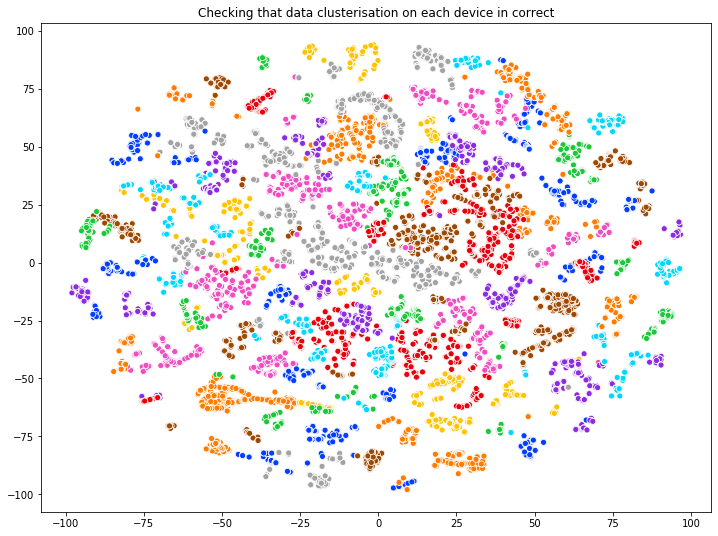

In [8]:
%%time
#Checking that splitting data by cluster is valid.
check_data_clusterisation(X,Y, nb_cluster)

In [9]:
# Creating cost models which will be used to computed cost/loss, gradients, L ...
cost_models = build_several_cost_model(RMSEModel, X_r, Y_r, nb_devices_for_the_run)

In [10]:
lenghts = [len(y) for y in Y_r]
print("max : {0}, min : {1}".format(max(lenghts), min(lenghts)))

max : 490, min : 60


In [11]:
%%time
obj_min_by_N = {}
obj_min_by_N_descent = FL_VanillaSGD(Parameters(n_dimensions = dim_notebook + 1, 
                                                nb_devices=nb_devices_for_the_run,
                                                nb_epoch=20000, 
                                                quantization_param=0,
                                                momentum = 0., 
                                                verbose=True, 
                                                cost_models=cost_models,
                                                stochastic=False,
                                                bidirectional=False
                                                ))
obj_min_by_N_descent.run(cost_models)
obj_min = obj_min_by_N_descent.losses[-1]

pickle_saver(obj_min, filename + "-noniid-obj_min")

   it    |   obj   
    4000 | 2.8127e-01
    8000 | 2.7459e-01
   12000 | 2.7138e-01
   16000 | 2.6956e-01
Gradient Descent: execution time=4625.837 seconds
Final loss : 0.26842

CPU times: user 4h 15min 26s, sys: 42min 29s, total: 4h 57min 55s
Wall time: 1h 17min 6s


## Batch size $= 10$, $\gamma = \frac{1}{L}$ 

In [12]:
def one_on_L(it, L, omega, N): return 1 / L

In [13]:
%%time
batch_size = 10
all_descent = {}
for type_params in tqdm(KIND_COMPRESSION):
    multiple_sg_descent = multiple_run_descent(type_params, cost_models=cost_models, 
                                               use_averaging=True, stochastic=True, batch_size=batch_size, 
                                               fraction_sampled_workers=0.5, step_formula=one_on_L,
                                               nb_epoch=1000, logs_file="{0}.txt".format(filename))
    all_descent[type_params.name()] = multiple_sg_descent
res = ResultsOfSeveralDescents(all_descent, len(X))
pickle_saver(res, "{0}-noniid-descent-b{1}-s1".format(filename, batch_size))

100%|██████████| 5/5 [5:16:23<00:00, 3796.64s/it]


CPU times: user 10h 30min 30s, sys: 1h 33min 35s, total: 12h 4min 6s
Wall time: 5h 16min 23s


### Without averaging

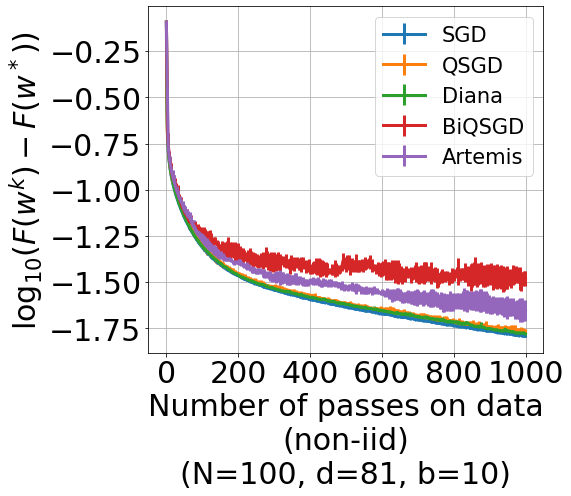

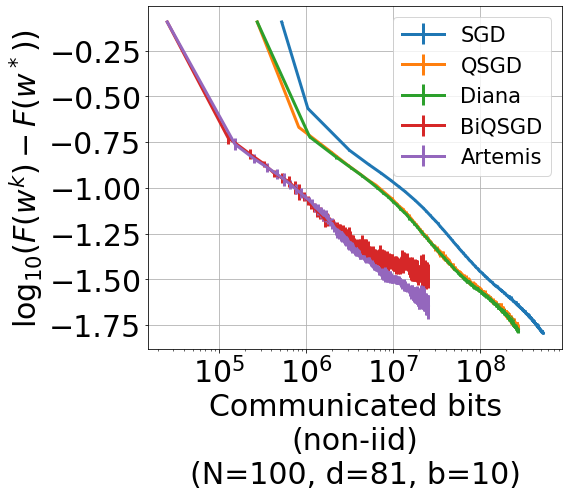

In [7]:
batch_size = 10
obj = pickle_loader("{0}-noniid-obj_min".format(filename))
res = pickle_loader("{0}-noniid-descent-b{1}-s1".format(filename, batch_size))

plot_error_dist(res.get_loss(obj), res.names, res.nb_devices_for_the_run, dim_notebook, batch_size=batch_size,
               all_error=res.get_std(obj), x_legend="Number of passes on data\n(non-iid)") 

plot_error_dist(res.get_loss(obj), res.names, res.nb_devices_for_the_run, dim_notebook,
                x_points=res.X_number_of_bits,  batch_size=batch_size,
                x_legend="Communicated bits\n(non-iid)", all_error=res.get_std(obj)) 

### With averaging

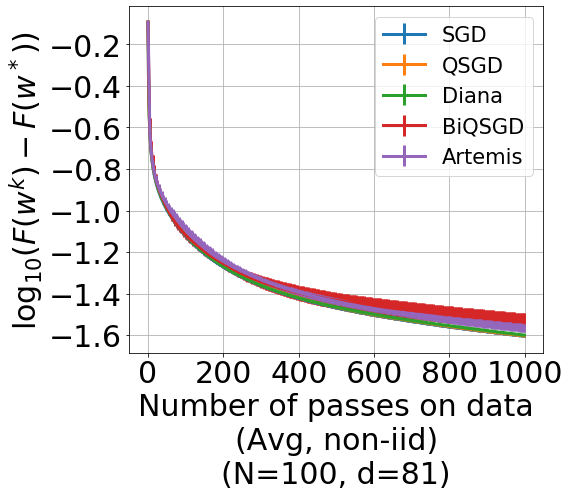

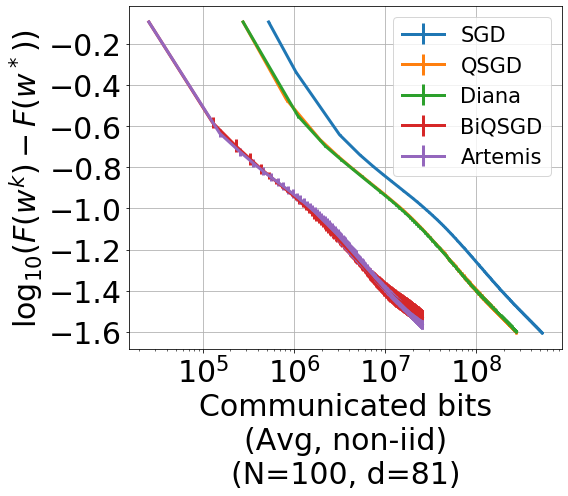

In [15]:
obj = pickle_loader("{0}-noniid-obj_min".format(filename))
res = pickle_loader("{0}-noniid-descent-b{1}-s1".format(filename, batch_size))

plot_error_dist(res.get_loss(obj, averaged=True), res.names, res.nb_devices_for_the_run, 
                dim_notebook, all_error=res.get_std(obj, averaged=True), 
                x_legend="Number of passes on data\n(Avg, non-iid)") 
plot_error_dist(res.get_loss(obj, averaged=True), res.names, res.nb_devices_for_the_run, dim_notebook, 
                x_points=res.X_number_of_bits, all_error=res.get_std(obj, averaged=True), 
                x_legend="Communicated bits\n(Avg, non-iid)") 


## Batch size $= 10$, $\gamma = \frac{1}{2L}$ 

In [16]:
def one_on_2L(it, L, omega, N): return 1 / (2*L)

In [17]:
%%time
batch_size = 10
all_descent = {}
for type_params in tqdm(KIND_COMPRESSION):
    multiple_sg_descent = multiple_run_descent(type_params, cost_models=cost_models, 
                                               use_averaging=True, stochastic=True, batch_size=batch_size, 
                                               fraction_sampled_workers=0.5, step_formula=one_on_2L,
                                               nb_epoch=1000, logs_file="{0}.txt".format(filename))
    all_descent[type_params.name()] = multiple_sg_descent
res = ResultsOfSeveralDescents(all_descent, len(X))
pickle_saver(res, "{0}-noniid-descent-b{1}-s2".format(filename, batch_size))

100%|██████████| 5/5 [3:04:45<00:00, 2217.04s/it]

CPU times: user 13h 54min 17s, sys: 1h 48min 6s, total: 15h 42min 23s
Wall time: 3h 4min 45s


### Without averaging

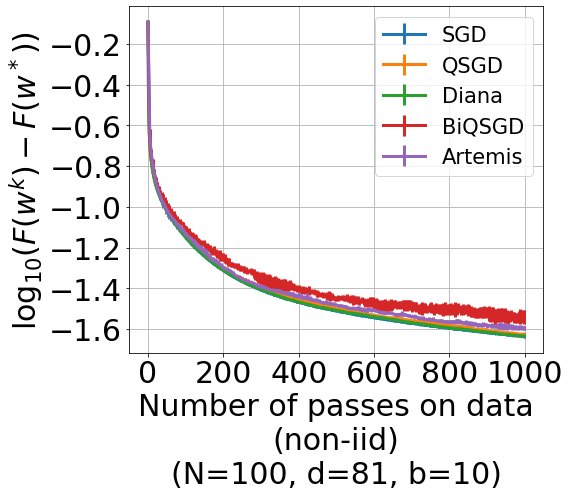

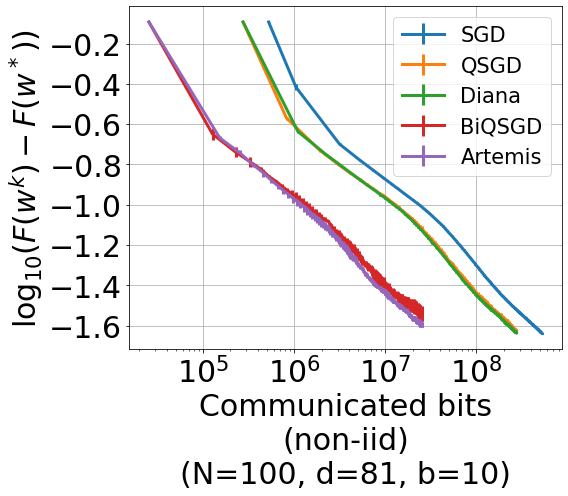

In [18]:
obj = pickle_loader("{0}-noniid-obj_min".format(filename))
res = pickle_loader("{0}-noniid-descent-b{1}-s2".format(filename, batch_size))

plot_error_dist(res.get_loss(obj), res.names, res.nb_devices_for_the_run, dim_notebook, batch_size=batch_size,
               all_error=res.get_std(obj), x_legend="Number of passes on data\n(non-iid)") 

plot_error_dist(res.get_loss(obj), res.names, res.nb_devices_for_the_run, dim_notebook,
                x_points=res.X_number_of_bits,  batch_size=batch_size,
                x_legend="Communicated bits\n(non-iid)", all_error=res.get_std(obj)) 

### With averaging

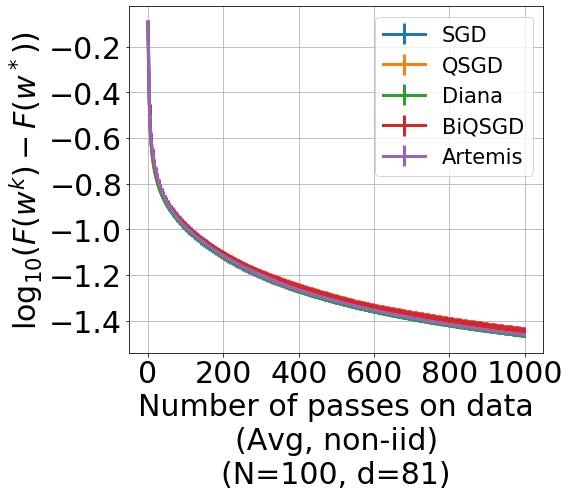

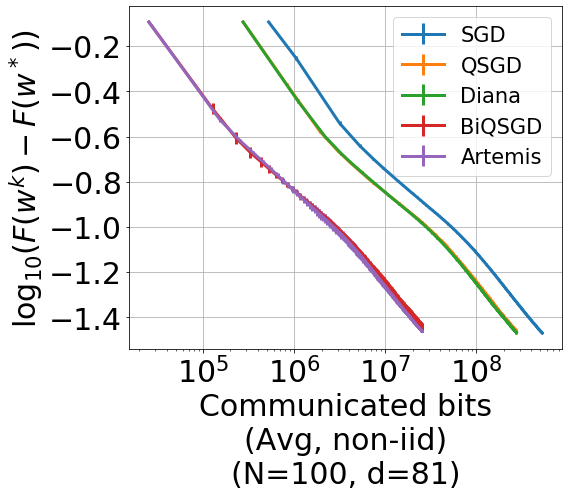

In [19]:
obj = pickle_loader("{0}-noniid-obj_min".format(filename))
res = pickle_loader("{0}-noniid-descent-b{1}-s2".format(filename, batch_size))

plot_error_dist(res.get_loss(obj, averaged=True), res.names, res.nb_devices_for_the_run, 
                dim_notebook, all_error=res.get_std(obj, averaged=True), 
                x_legend="Number of passes on data\n(Avg, non-iid)") 
plot_error_dist(res.get_loss(obj, averaged=True), res.names, res.nb_devices_for_the_run, dim_notebook, 
                x_points=res.X_number_of_bits, all_error=res.get_std(obj, averaged=True), 
                x_legend="Communicated bits\n(Avg, non-iid)") 


## Full batch, $\gamma = \frac{1}{L}$ 

In [20]:
%%time
all_descent = {}
for type_params in tqdm(KIND_COMPRESSION):
    multiple_sg_descent = multiple_run_descent(type_params, cost_models=cost_models, 
                                               use_averaging=True, stochastic=False, 
                                               nb_epoch=1000, fraction_sampled_workers=0.5,
                                               step_formula=one_on_L,
                                               logs_file="{0}.txt".format(filename))
    all_descent[type_params.name()] = multiple_sg_descent
res = ResultsOfSeveralDescents(all_descent, len(X))
pickle_saver(res, "{0}-noniid-descent-full".format(filename, batch_size))

100%|██████████| 5/5 [55:14<00:00, 662.83s/it]

CPU times: user 6h 30min 26s, sys: 47min 31s, total: 7h 17min 58s
Wall time: 55min 14s


### Without averaging

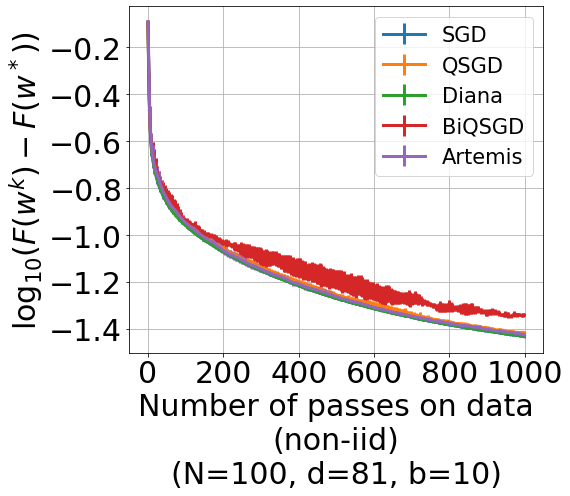

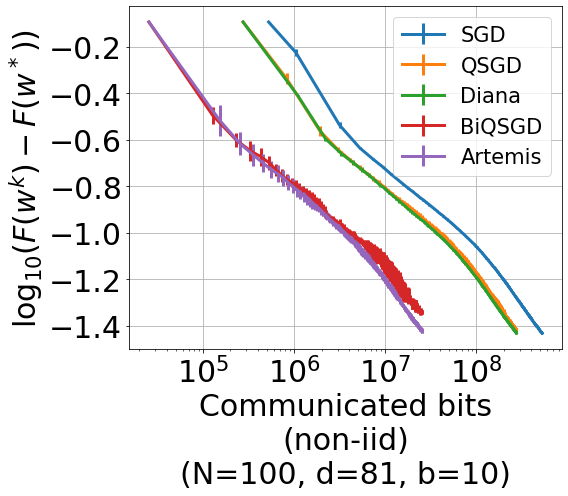

In [21]:
obj = pickle_loader("{0}-noniid-obj_min".format(filename))
res = pickle_loader("{0}-noniid-descent-full".format(filename, batch_size))

plot_error_dist(res.get_loss(obj), res.names, res.nb_devices_for_the_run, dim_notebook, batch_size=batch_size,
               all_error=res.get_std(obj), x_legend="Number of passes on data\n(non-iid)") 

plot_error_dist(res.get_loss(obj), res.names, res.nb_devices_for_the_run, dim_notebook,
                x_points=res.X_number_of_bits,  batch_size=batch_size,
                x_legend="Communicated bits\n(non-iid)", all_error=res.get_std(obj)) 

### With averaging

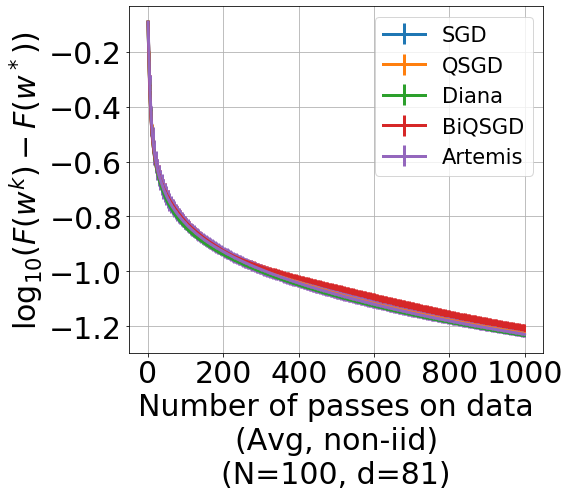

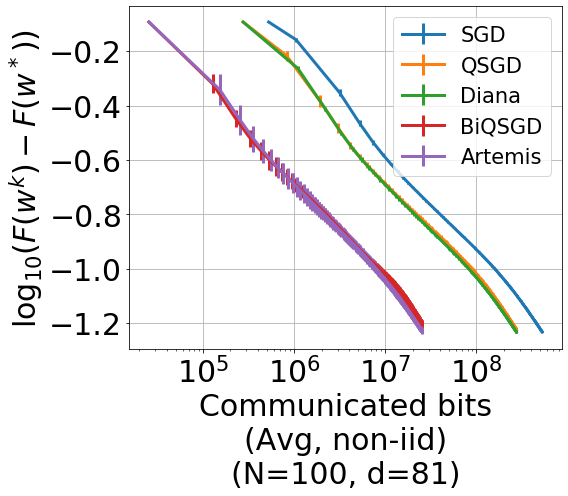

In [22]:
obj = pickle_loader("{0}-noniid-obj_min".format(filename))
res = pickle_loader("{0}-noniid-descent-full".format(filename, batch_size))

plot_error_dist(res.get_loss(obj, averaged=True), res.names, res.nb_devices_for_the_run, 
                dim_notebook, all_error=res.get_std(obj, averaged=True), 
                x_legend="Number of passes on data\n(Avg, non-iid)") 
plot_error_dist(res.get_loss(obj, averaged=True), res.names, res.nb_devices_for_the_run, dim_notebook, 
                x_points=res.X_number_of_bits, all_error=res.get_std(obj, averaged=True), 
                x_legend="Communicated bits\n(Avg, non-iid)") 
